# Imports and settings

### Microbiome-based Obesity Analysis <br> Statistical Association and Predictive Modeling

In this notebook, we analyze gut microbiome data in order to study the relationship between bacterial taxa and obesity.

The goals of this analysis are twofold:
1. **Statistical association**: identify bacterial taxa whose abundances differ significantly between lean and obese individuals.
2. **Predictive modeling**: evaluate whether gut microbiome composition can be used to predict obesity status.

The dataset was obtained from the *LeChatelierE_2013* study via the curatedMetagenomicData framework.  
Initial data acquisition, filtering, and preprocessing were performed in a separate notebook and are summarized below.

Our Final Research Question: <br>Which gut bacterial taxa are associated with obesity (BMI ≥ 30 vs BMI ≤ 25), and how well can gut microbiome composition predict obesity status?


In [99]:
import numpy as np
import MIPMLP
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from MIPMLP import preprocess

from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_auc_score, roc_curve, auc
)

# Set visual style
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# 1. Data Loading & The "Data Challenge"

In this section, we load the raw abundance data and metadata, then define our target groups (Lean vs. Obese). We also explore the unique challenges posed by microbiome data.

In [100]:
# Load Metadata and Abundance data
meta_raw = pd.read_csv('Data/Raw_LeChatelier_metadata.csv', index_col=0)
X_raw = pd.read_csv('Data/Raw_LeChatelier_relative_abundance.csv', index_col=0)

print(f"Metadata shape: {meta_raw.shape}")
print(f"Abundance matrix shape: {X_raw.shape}")

# Filter for Lean (BMI <= 25) and Obese (BMI >= 30)
meta_filtered = meta_raw[(meta_raw['BMI'] <= 25) | (meta_raw['BMI'] >= 30)].copy()
meta_filtered['group'] = np.where(meta_filtered['BMI'] <= 25, 'Lean', 'Obese')

# Align abundance data with filtered metadata
X = X_raw.loc[meta_filtered.index]
y = meta_filtered['group']

print(f"\nFinal dataset shape: {X.shape}")
print(f"Class distribution:\n{y.value_counts()}")

Metadata shape: (292, 21)
Abundance matrix shape: (292, 526)

Final dataset shape: (265, 526)
Class distribution:
group
Obese    169
Lean      96
Name: count, dtype: int64


## 1.1 Data Preprocessing using MIPMLP

We use the course's official pipeline (MIPMLP) for data preprocessing. This pipeline includes:
1. **Taxonomy Aggregation**: Ensuring data is at the Species level (Level 7).
2. **Normalization**: Applying Relative Normalization.
3. **Filtering**: Removing rare taxa that appear in fewer than 1% of samples.

*Note: We perform Log Transformation explicitly in downstream steps (visualizations and modeling) as per the pipeline's flexibility.*

In [101]:
# Prepare X for MIPMLP (Requires 'ID' column and 'taxonomy' row)
X_mip = X.copy()
X_mip['ID'] = X_mip.index
X_mip = X_mip.astype(object)
X_mip.loc['taxonomy'] = pd.Series(X_mip.columns, index=X_mip.columns)
X_mip.loc['taxonomy', 'ID'] = 'taxonomy'

# Run MIPMLP Preprocess
# Using rare_bacteria_threshold=0.01 (1%) as per default tool settings
# Using normalization='relative' to keep data relative for subsequent log-transform in ML/Plots
X_processed = preprocess(
    X_mip, 
    taxonomy_level=7, 
    taxnomy_group='sum', 
    normalization='relative', 
    rare_bacteria_threshold=0.01,
    plot=False
)

# Update X with processed data
X = X_processed

print(f"Original shape: {X_raw.shape}")
print(f"Processed shape (after MIPMLP filtering): {X.shape}")

# Re-calculate sparsity
new_sparsity = (X == 0).sum().sum() / X.size
print(f"New Global Sparsity: {new_sparsity:.2%}")

c:\Users\liorbj\AppData\Local\anaconda3\Lib\site-packages\MIPMLP\preprocess_grid.py:48: FutureWarning:

errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead

c:\Users\liorbj\AppData\Local\anaconda3\Lib\site-packages\MIPMLP\preprocess_grid.py:56: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

c:\Users\liorbj\AppData\Local\anaconda3\Lib\site-packages\MIPMLP\preprocess_grid.py:57: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

c:\Users\liorbj\AppData\Local\anaconda3\Lib\site-packages\MIPMLP\preprocess_grid.py:58: FutureWarning:

S

Original shape: (292, 526)
Processed shape (after MIPMLP filtering): (265, 373)
New Global Sparsity: 71.25%


### The Microbiome Data Challenge
Working with gut microbiome data presents several statistical and computational challenges:
1. **High Dimensionality:** We often have hundreds or thousands of bacterial taxa (features) for a relatively small number of patients.
2. **Sparsity:** Microbiome matrices are "zero-heavy" because most taxa are not present in every individual.
3. **Compositionality & Skewness:** Abundance values are relative (sum to 100%) and often follow a heavy-tailed distribution, where a few taxa dominate and many others are rare.

Global Sparsity: 71.25%


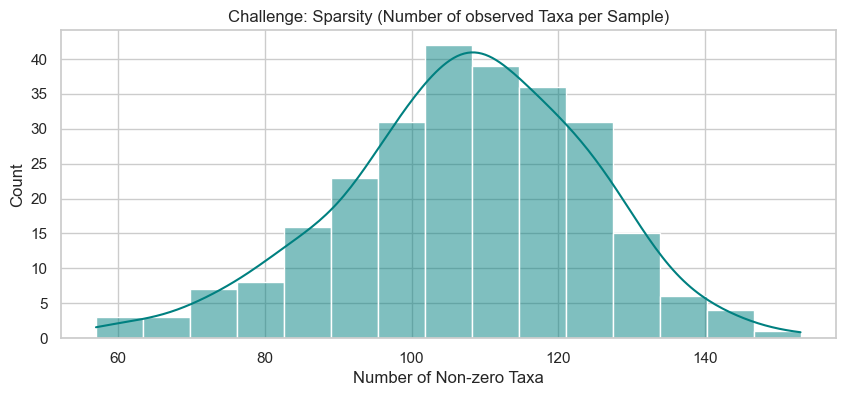

In [102]:
# Challenge 1: Sparsity
sparsity = (X == 0).sum().sum() / X.size
print(f"Global Sparsity: {sparsity:.2%}")

plt.figure(figsize=(10, 4))
nonzero_counts = (X > 0).sum(axis=1)
sns.histplot(nonzero_counts, kde=True, color='teal')
plt.title("Challenge: Sparsity (Number of observed Taxa per Sample)")
plt.xlabel("Number of Non-zero Taxa")
plt.show()

C:\Users\liorbj\AppData\Local\Temp\ipykernel_36564\368846102.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




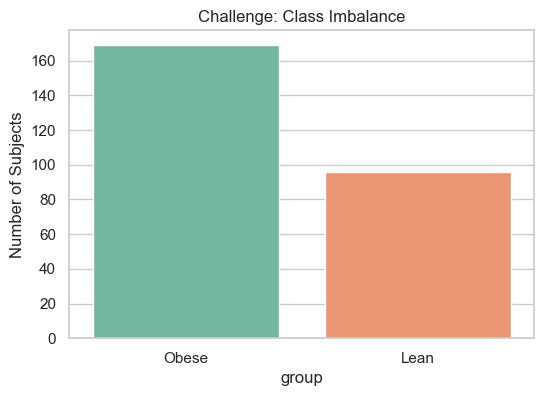

In [103]:
# Challenge 2: Class Imbalance
plt.figure(figsize=(6, 4))
sns.countplot(x=y, palette=['#66c2a5', '#fc8d62'])
plt.title("Challenge: Class Imbalance")
plt.ylabel("Number of Subjects")
plt.show()

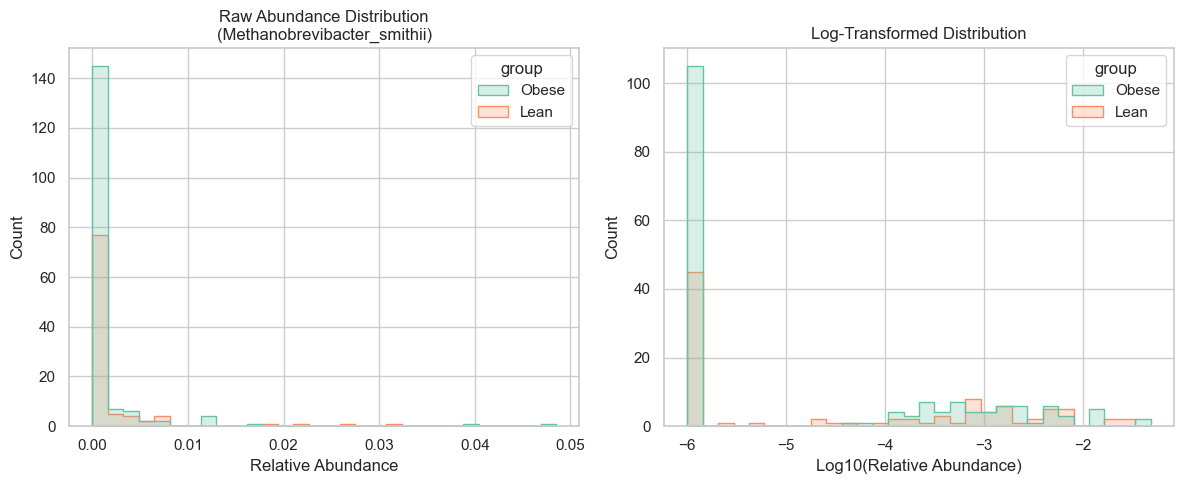

In [104]:
# Challenge 3: Skewness & The need for Log Transformation
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sample_taxon = X.columns[0] # Pick the first taxon as an example

sns.histplot(x=X[sample_taxon], hue=y, bins=30, ax=axes[0], palette=['#66c2a5', '#fc8d62'], element="step", common_norm=False)
axes[0].set_title(f"Raw Abundance Distribution\n({sample_taxon.split('|')[-1]})")
axes[0].set_xlabel("Relative Abundance")

# Apply Log Transformation (with pseudo-count)
X_log = np.log10(X + 1e-6)

sns.histplot(x=X_log[sample_taxon], hue=y, bins=30, ax=axes[1], palette=['#66c2a5', '#fc8d62'], element="step", common_norm=False)
axes[1].set_title(f"Log-Transformed Distribution")
axes[1].set_xlabel("Log10(Relative Abundance)")
plt.tight_layout()
plt.show()

### Hypothesis Check: Is "Balance" the key?

We observed that looking at a random taxon might not show a clear signal. Let's find the **most significant taxon** in our dataset (the one with the lowest p-value between Lean and Obese) and test the "Goldilocks Hypothesis" on it.

We categorize its abundance into:
1. **Absent**: 0 abundance
2. **Intermediate**: > 0 but below the median of non-zero values
3. **High**: Above the median of non-zero values

Switching analysis to most significant taxon: Fretibacterium_fastidiosum (p=4.65e-05)


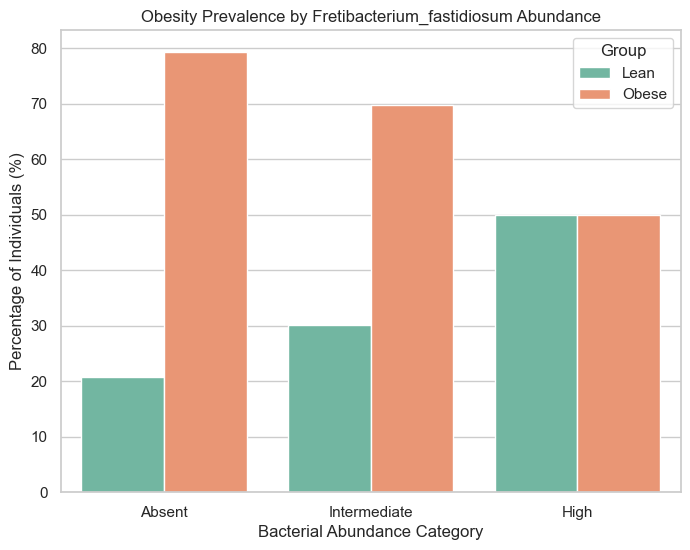

Group distribution per category:
Group         Lean  Obese
Category                 
Absent        20.8   79.2
High          50.0   50.0
Intermediate  30.2   69.8


In [105]:
# Find the most significant taxon first
p_values = {}
for taxon in X.columns:
    group1 = X.loc[y == 'Lean', taxon]
    group2 = X.loc[y == 'Obese', taxon]
    _, p = mannwhitneyu(group1, group2)
    p_values[taxon] = p

best_taxon = min(p_values, key=p_values.get)
print(f"Switching analysis to most significant taxon: {best_taxon.split('|')[-1]} (p={p_values[best_taxon]:.2e})")

# Define thresholds based on non-zero data
taxon_data = X[best_taxon]
nonzero_data = taxon_data[taxon_data > 0]
median_nonzero = nonzero_data.median()

# Categorize
conditions = [
    (taxon_data == 0),
    (taxon_data > 0) & (taxon_data <= median_nonzero),
    (taxon_data > median_nonzero)
]
categories = ['Absent', 'Intermediate', 'High']
df_cat = pd.DataFrame({'Category': np.select(conditions, categories, default='Unknown'), 'Group': y})

# Calculate proportions
prop_data = df_cat.groupby(['Category', 'Group']).size().reset_index(name='Count')
total_per_cat = prop_data.groupby('Category')['Count'].transform('sum')
prop_data['Percentage'] = prop_data['Count'] / total_per_cat * 100

# Order categories logic
category_order = ['Absent', 'Intermediate', 'High']

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(data=prop_data, x='Category', y='Percentage', hue='Group', 
            order=category_order, palette=['#66c2a5', '#fc8d62'])
plt.title(f"Obesity Prevalence by {best_taxon.split('|')[-1]} Abundance")
plt.ylabel("Percentage of Individuals (%)")
plt.xlabel("Bacterial Abundance Category")
plt.legend(title='Group')
plt.show()

print("Group distribution per category:")
print(pd.crosstab(df_cat['Category'], df_cat['Group'], normalize='index').round(3) * 100)

<div style="padding: 15px; border-radius: 10px; background-color: #f0f7f4; border-left: 5px solid #66c2a5;">
    <h3 style="color: #1e5631; margin: 0;">🔬 Conclusion: High Abundance is Protective</h3>
    <p style="color: #34495e; margin: 10px 0;">
        Contrary to the "Balance" hypothesis, <b>High Abundance</b> of <i>Fretibacterium fastidiosum</i> correlates with lower obesity risk.
    </p>
    <ul style="color: #7f8c8d; margin-bottom: 0;">
        <li><b style="color: #d35400;">Low/Absent:</b> ~80% Obese (High Risk).</li>
        <li><b style="color: #27ae60;">High:</b> ~50% Lean (Doubled chance of being Lean).</li>
    </ul>
</div>

# 2. Statistical Association Analysis

We use the non-parametric Mann-Whitney U test to identify taxa that differ significantly between Lean and Obese individuals. Since we are testing hundreds of taxa, we must apply a Multiple Testing Correction (Benjamini-Hochberg FDR).

In [106]:
# Separate data into two groups
X_lean = X[y == 'Lean']
X_obese = X[y == 'Obese']

results = []
for taxon in X.columns:
    # Perform Mann-Whitney U test
    stat, pval = mannwhitneyu(X_lean[taxon], X_obese[taxon], alternative='two-sided')
    
    # Calculate mean abundance for each group
    mean_lean = X_lean[taxon].mean()
    mean_obese = X_obese[taxon].mean()
    
    # Calculate Log2 Fold Change (adding a small epsilon to avoid log(0))
    # Note: Using means of relative abundances
    l2fc = np.log2((mean_obese + 1e-6) / (mean_lean + 1e-6))
    
    results.append({
        'taxon': taxon,
        'p_value': pval,
        'mean_lean': mean_lean,
        'mean_obese': mean_obese,
        'log2fc': l2fc
    })

df_stats = pd.DataFrame(results)

# Apply Benjamini-Hochberg FDR correction
_, df_stats['fdr_q_value'], _, _ = multipletests(df_stats['p_value'], method='fdr_bh')

# Filter for significant taxa (FDR < 0.1 as a common discovery threshold in microbiome)
significant_taxa = df_stats[df_stats['fdr_q_value'] < 0.1].sort_values('fdr_q_value')

print(f"Found {len(significant_taxa)} significant taxa at FDR < 0.1")
significant_taxa.head(10)

Found 8 significant taxa at FDR < 0.1


,taxon,p_value,mean_lean,mean_obese,log2fc,fdr_q_value
168,Clostridium_sp_CAG_58,0.000072,0.000411,0.000982,1.254314,0.013462
370,Fretibacterium_fastidiosum,0.000046,0.000071,0.000037,-0.903276,0.013462
237,Roseburia_sp_CAG_303,0.000350,0.001073,0.000106,-3.325421,0.043492
238,Roseburia_sp_CAG_309,0.000544,0.001011,0.000278,-1.860341,0.050744
171,Clostridium_sp_CAG_964,0.000791,0.001136,0.000019,-5.817322,0.059029
298,Firmicutes_bacterium_CAG_555,0.001280,0.001324,0.000751,-0.816804,0.079584
30,Denitrobacterium_detoxificans,0.001775,0.000015,0.000005,-1.374796,0.082737
269,Ruminococcus_lactaris,0.001674,0.004147,0.002688,-0.625679,0.082737


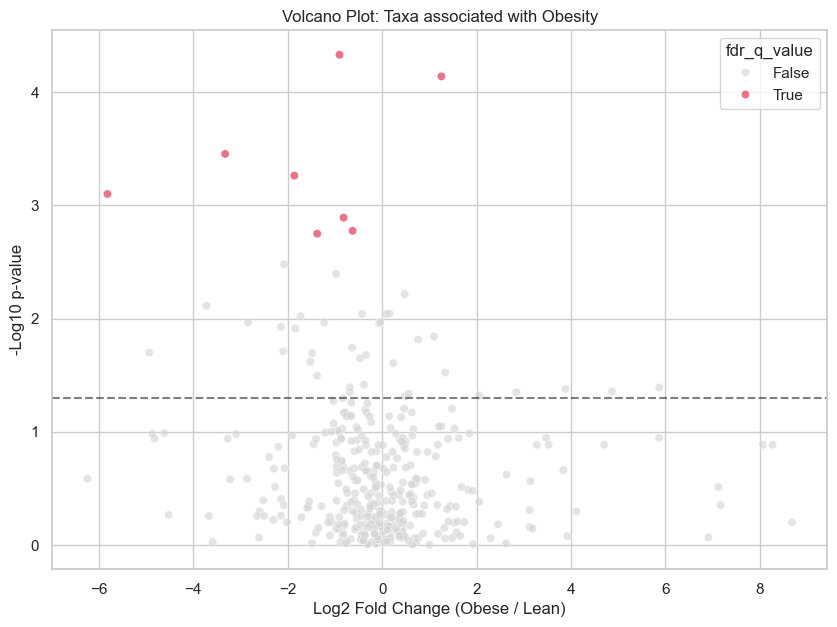

In [107]:
# Volcano Plot
plt.figure(figsize=(10, 7))
df_stats['neg_log10_p'] = -np.log10(df_stats['p_value'])

sns.scatterplot(
    data=df_stats, x='log2fc', y='neg_log10_p', 
    hue=df_stats['fdr_q_value'] < 0.1, 
    palette={True: 'crimson', False: 'lightgrey'}, alpha=0.6
)

plt.axhline(-np.log10(0.05), color='black', linestyle='--', alpha=0.5)
plt.title("Volcano Plot: Taxa associated with Obesity")
plt.xlabel("Log2 Fold Change (Obese / Lean)")
plt.ylabel("-Log10 p-value")
plt.show()

# 3. Predictive Modeling

Can we predict if a person is Lean or Obese based on their microbiome? We use Logistic Regression with L1 regularization (Lasso) to both predict and identify the most important features.

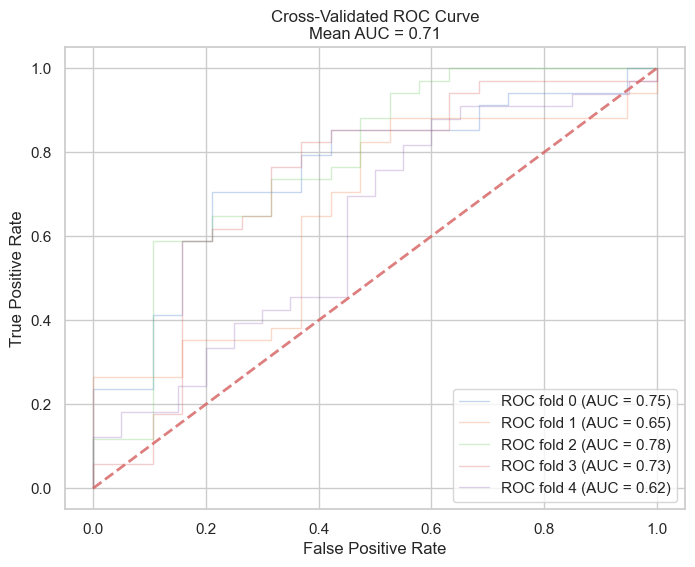

Average AUC: 0.71 (+/- 0.06)


In [108]:
# Encode target
y_numeric = (y == 'Obese').astype(int)

# Log transform X (as seen in Challenge 3)
X_ml = np.log10(X + 1e-6)

# Build Pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(penalty='l1', solver='liblinear', C=1.0, class_weight='balanced'))
])

# Evaluation with Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

aucs = []
plt.figure(figsize=(8, 6))

for i, (train_index, test_index) in enumerate(skf.split(X_ml, y_numeric)):
    X_train, X_test = X_ml.iloc[train_index], X_ml.iloc[test_index]
    y_train, y_test = y_numeric.iloc[train_index], y_numeric.iloc[test_index]
    
    pipe.fit(X_train, y_train)
    y_score = pipe.predict_proba(X_test)[:, 1]
    
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label=f'ROC fold {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.8)
plt.title(f'Cross-Validated ROC Curve\nMean AUC = {np.mean(aucs):.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

print(f"Average AUC: {np.mean(aucs):.2f} (+/- {np.std(aucs):.2f})")

### Feature Importance

Which taxa were most important for the model's prediction? We can look at the coefficients of the L1-regularized Logistic Regression.

C:\Users\liorbj\AppData\Local\Temp\ipykernel_36564\868203914.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




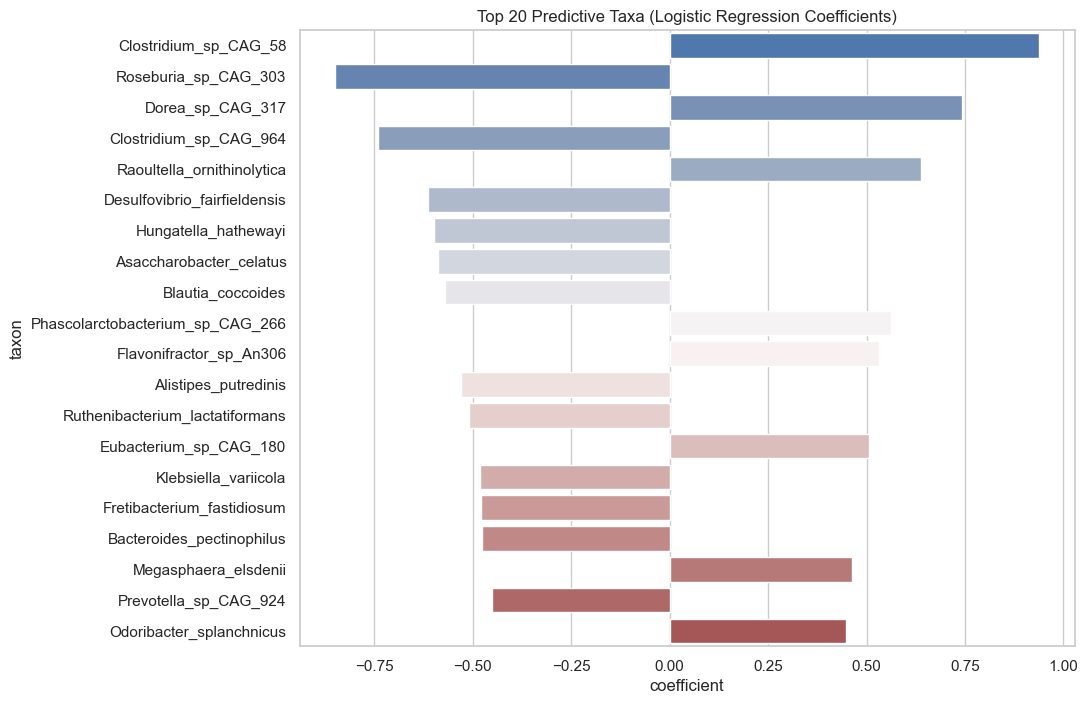

Number of features selected by Lasso: 134


,taxon,coefficient
168,Clostridium_sp_CAG_58,0.939155
237,Roseburia_sp_CAG_303,-0.850520
214,Dorea_sp_CAG_317,0.741601
171,Clostridium_sp_CAG_964,-0.741541
357,Raoultella_ornithinolytica,0.638221
340,Desulfovibrio_fairfieldensis,-0.612739
172,Hungatella_hathewayi,-0.599148
29,Asaccharobacter_celatus,-0.587268
198,Blautia_coccoides,-0.570761
308,Phascolarctobacterium_sp_CAG_266,0.562495


In [109]:
# Train on full dataset to get final coefficients
pipe.fit(X_ml, y_numeric)
coefs = pipe.named_steps['clf'].coef_[0]
feature_names = X.columns

importance_df = pd.DataFrame({
    'taxon': feature_names,
    'coefficient': coefs
}).sort_values('coefficient', key=abs, ascending=False)

# Filter for non-zero coefficients
importance_df = importance_df[importance_df['coefficient'] != 0]

plt.figure(figsize=(10, 8))
sns.barplot(
    data=importance_df.head(20), 
    x='coefficient', y='taxon', palette='vlag'
)
plt.title("Top 20 Predictive Taxa (Logistic Regression Coefficients)")
plt.show()

print(f"Number of features selected by Lasso: {len(importance_df)}")
importance_df.head(10)

<div style="padding: 30px; border-radius: 20px; background: linear-gradient(135deg, #e0f2f1 0%, #f1f8e9 100%); border: 2px solid #81c784; box-shadow: 0 10px 20px rgba(0,0,0,0.05);">
    <h2 style="color: #2e7d32; margin-top: 0; text-align: center; border-bottom: 2px solid #81c784; padding-bottom: 10px;">
        🏁 Phase 1 Complete
    </h2>
    <p style="font-size: 1.2em; color: #37474f; text-align: center; margin: 20px 0;">
        We have established a robust baseline analysis using the <b>MIPMLP pipeline</b>, identified key bacterial biomarkers, and demonstrated significant predictive potential for obesity status.
    </p>
    <div style="background: white; padding: 20px; border-radius: 15px; border-left: 8px solid #2e7d32;">
        <h4 style="color: #1b5e20; margin-top: 0;"> Roadmap for Phase 2 (Expansion)</h4>
        <ul style="color: #546e7a; line-height: 1.8; font-size: 1.05em;">
            <li><b>Model Benchmarking:</b> Comparative analysis of <i>Logistic Regression</i> vs. <i>Random Forest</i> and <i>XGBoost</i> to optimize non-linear signal capture.</li>
            <li><b>Advanced Evaluation:</b> Integration of <i>Confusion Matrices</i>, <i>Precision-Recall</i> curves, and <i>F1-score</i> benchmarks for a more granular performance overview.</li>
            <li><b>Robustness Testing:</b> Explicit checks for <i>Overfitting</i> using training vs. validation loss curves.</li>
            <li><b>Clinical Storytelling:</b> Deeper biological investigation into the specific roles of top predictive taxa in metabolic health.</li>
        </ul>
    </div>
    <p style="text-align: center; margin-top: 25px; font-style: italic; color: #66bb6a; font-weight: bold;">
        Moving forward to turn these preliminary results into a full scientific report.
    </p>
</div>